In [1]:
import pandas as pd
import numpy as np
import pylab as plt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale
from scipy.stats import multivariate_normal
from scipy.io import loadmat
from mne.decoding import delay_time_series

from tqdm import tqdm
import mne

rng = np.random.RandomState(1337) 
%matplotlib inline

# Regression with two variables: direction matters
Show that the regression solution differs when you do $y=wx$ vs. $x=wy$

In [2]:
n = 500
noise_amt = 2

a = rng.randn(n)
weight = 2
b = weight * a + rng.randn(n) * noise_amt

[(-9.3337246133748906, 10.383805624862866)]

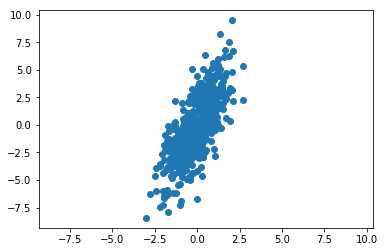

In [3]:
fig, ax = plt.subplots()
ax.plot(a, b, 'o')
ax.set(xlim=ax.get_ylim())

[(-9.4991265738801687, 10.391681908696452)]

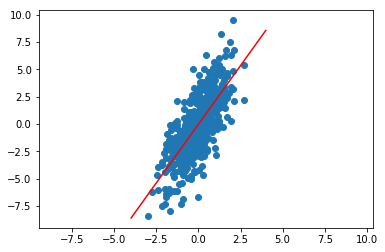

In [4]:
test_pts_b = np.linspace(-4, 4, 1000)[:, np.newaxis]

mod = LinearRegression()
mod.fit(a[:, np.newaxis], b)
preds_b = mod.predict(test_pts_b)

fig, ax = plt.subplots()
ax.plot(a, b, 'o')


ax.plot(test_pts_b, preds_b, 'r-')
ax.set(xlim=ax.get_ylim())

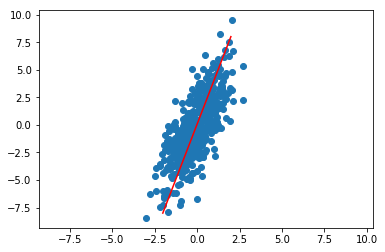

In [5]:
test_pts_a = np.linspace(-8, 8, 1000)[:, np.newaxis]

mod = LinearRegression()
mod.fit(b[:, np.newaxis], a)
preds_a = mod.predict(test_pts_a)

fig, ax = plt.subplots()
ax.plot(a, b, 'o')

ax.plot(preds_a, test_pts_a, 'r-')
_ = ax.set(xlim=ax.get_ylim())

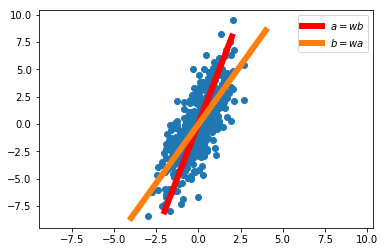

In [6]:
kwargs = dict(lw=6)
fig, ax = plt.subplots()
ax.plot(a, b, 'o')
ln1 = ax.plot(preds_a, test_pts_a, 'r-', **kwargs)
ln2 = ax.plot(test_pts_b, preds_b, '-', **kwargs)
_ = ax.set(xlim=ax.get_ylim())
ax.legend(ax.lines[1:], ['$a=wb$', '$b=wa$'])

# Now with real data
We'll use natural speech along with an artificial STRF to simulate an artifical electrode's response to the audio. Then we'll attempt to uncover the STRF using both encoding and decoding methods

In [7]:
# Read in audio that's been recorded in epochs.
path_audio = mne.datasets.mtrf.data_path()
data = loadmat(path_audio + '/speech_data.mat')
audio = data['spectrogram'].T
sfreq = float(data['Fs'][0, 0])
n_decim = 2
audio = mne.filter.resample(audio, down=n_decim, npad='auto')
sfreq /= n_decim

## Simulating the receptive field

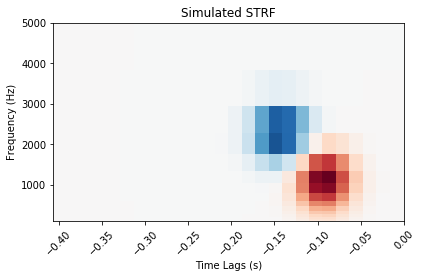

In [8]:
n_freqs = 16
tmin, tmax = -.4, 0.

# To simulate the data we'll create explicit delays here
delays_samp = np.arange(np.round(tmin * sfreq),
                        np.round(tmax * sfreq) + 1).astype(int)
delays_sec = delays_samp / sfreq
freqs = np.logspace(2, np.log10(5000), n_freqs)
grid = np.array(np.meshgrid(delays_sec, freqs))

# We need data to be shaped as n_epochs, n_features, n_times, so swap axes here
grid = grid.swapaxes(0, -1).swapaxes(0, 1)

# Simulate a temporal receptive field with a Gabor filter
means_high = [-.1, 1000]
means_low = [-.15, 2000]
cov = [[.0005, 0], [0, 200000]]
gauss_high = multivariate_normal.pdf(grid, means_high, cov)
gauss_low = -1 * multivariate_normal.pdf(grid, means_low, cov)
weights = gauss_high + gauss_low  # Combine to create the "true" STRF
kwargs = dict(vmax=np.abs(weights).max(), vmin=-np.abs(weights).max(),
              cmap='RdBu_r')

fig, ax = plt.subplots()
ax.pcolormesh(delays_sec, freqs, weights, **kwargs)
ax.set(title='Simulated STRF', xlabel='Time Lags (s)', ylabel='Frequency (Hz)')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.autoscale(tight=True)
mne.viz.tight_layout()

## Simulating a neural response

Using this receptive field, we'll create an artificial neural response to a stimulus.

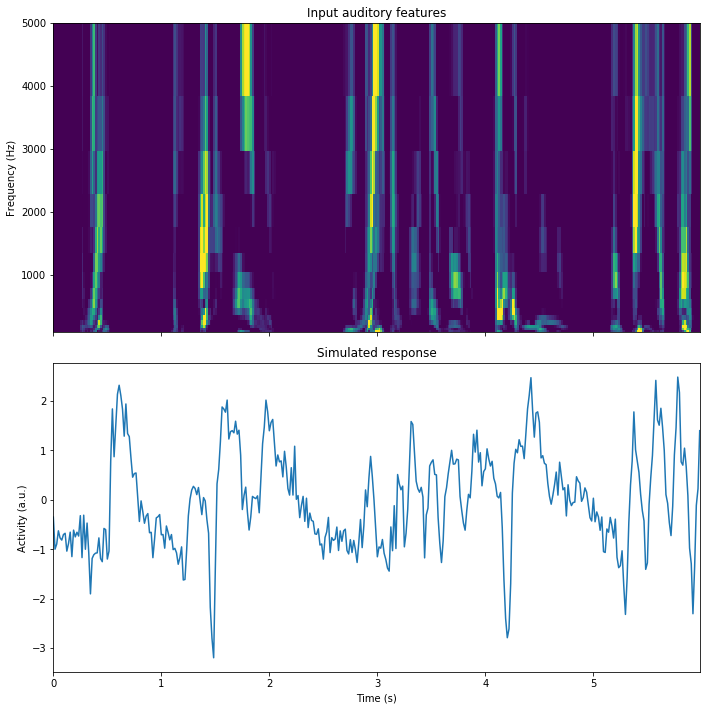

In [9]:
# Reshape audio to split into epochs, then make epochs the first dimension.
n_epochs, n_seconds = 30, 3
audio = audio[:, :int(n_seconds * sfreq * n_epochs)]
X = audio.reshape([n_freqs, n_epochs, -1]).swapaxes(0, 1)
n_times = X.shape[-1]

# Delay the spectrogram according to delays so it can be combined w/ the STRF
# Lags will now be in axis 1, then we reshape to vectorize
X_del = delay_time_series(X, tmin, tmax, sfreq, newaxis=1, axis=-1)
delays = np.round(np.arange(tmin * sfreq, tmax * sfreq + 1)).astype(int)
X_del = X_del.reshape([n_epochs, -1, n_times])
n_features = X_del.shape[1]
weights_sim = weights.ravel()

# Simulate a neural response to the sound, given this STRF
y = np.zeros([n_epochs, n_times])
for ii, iep in enumerate(X_del):
    # Simulate this epoch and add random noise
    noise_amp = .0005
    y[ii] = np.dot(weights_sim, iep) + noise_amp * rng.randn(n_times)

# Plot the first 2 trials of audio and the simulated electrode activity
X_plt = scale(np.hstack(X[:2]).T).T
y_plt = scale(np.hstack(y[:2]))
time = np.arange(X_plt.shape[-1]) / sfreq
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
axs[0].pcolormesh(time, freqs, X_plt, vmin=0, vmax=4, cmap='viridis')
axs[0].set_title('Input auditory features')
axs[0].set(ylim=[freqs.min(), freqs.max()], ylabel='Frequency (Hz)')
axs[1].plot(time, y_plt)
axs[1].set(xlim=[time.min(), time.max()], title='Simulated response',
           xlabel='Time (s)', ylabel='Activity (a.u.)')
mne.viz.tight_layout()

## Recovering the STRF with an encoding model

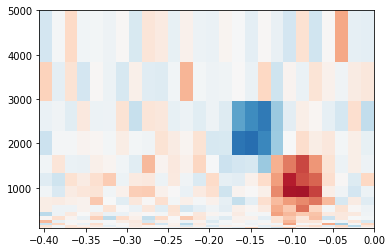

In [10]:
mod = Ridge(alpha=.01)
X_fit = np.hstack(X_del).T
y_fit = np.hstack(y).T
mod.fit(X_fit, y_fit)
coefs_encoding = mod.coef_.reshape((n_freqs, len(delays_samp)))
fig, ax = plt.subplots()
ax.pcolormesh(delays_sec, freqs, coefs_encoding, **kwargs)

## Recovering the STRF with a decoding model

Reshape our input data so features aren't vectorized

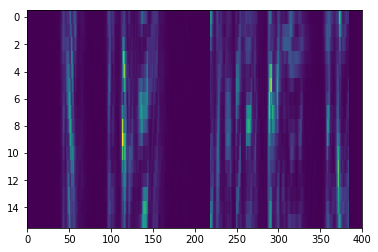

In [11]:
X_fit_decoding = np.hstack(X_del)
X_fit_decoding = X_fit_decoding.reshape([len(delays), n_freqs, -1])
X_fit_decoding = X_fit_decoding.swapaxes(0, 1)

fig, ax = plt.subplots()
# First dimension is frequency band, second is time lag, third is times
ax.imshow(X_fit_decoding[:, 0, :400], aspect='auto')

In [12]:
mod = Ridge(alpha=1.)

# Loop through each spectrogram frequency band / time lag, fit a model for each
coefs_decoding = np.zeros([n_freqs, len(delays)])
for i_freq, i_data_f in enumerate(X_fit_decoding):
    for i_lag, i_data_l in enumerate(i_data_f):
        mod.fit(y_fit[:, np.newaxis], i_data_l)
        
        # Populate from bottom to top / right to left
        coefs_decoding[i_freq, len(delays) - i_lag - 1] = mod.coef_[0]

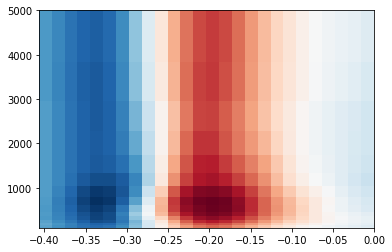

In [13]:
# Plot the results
fig, ax = plt.subplots()
ax.pcolormesh(delays_sec, freqs, coefs_decoding, cmap=plt.cm.RdBu_r)

## Comparing encoding and decoding weights

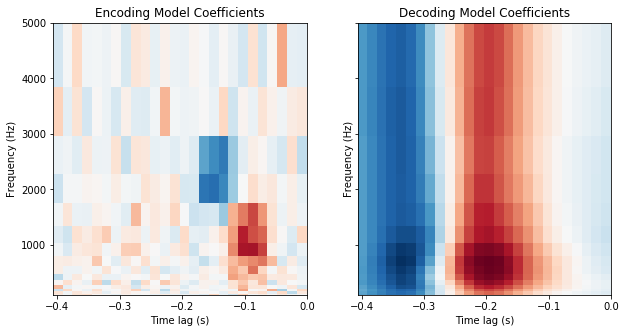

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5),
                               sharex=True, sharey=True)
ax1.pcolormesh(delays_sec, freqs, coefs_encoding, **kwargs)
ax1.set(title='Encoding Model Coefficients')
ax2.pcolormesh(delays_sec, freqs, coefs_decoding, cmap=plt.cm.RdBu_r)
ax2.set(title='Decoding Model Coefficients')

_ = plt.setp([ax1, ax2], xlabel='Time lag (s)', ylabel='Frequency (Hz)')
